# Pricing de Opciones

Construiremos la superficie de volatilidad de las opciones del S&P500 y valuaremos instrumentos con la misma.

In [1]:
from scipy.stats import norm
from math import *
import eikon as ek
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import warnings
warnings.filterwarnings("ignore")
import datetime
from datetime import time, timedelta, date
from IPython.display import Image
from sklearn import linear_model

In [2]:
ek.set_app_key('958286cafdf34bf7b8a9c341e66aa9d57bd6b15a')

Black-Scholes

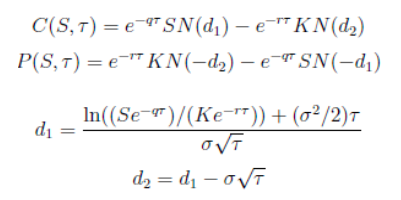

In [3]:
Image("Blacks.png")

-Black-Scholes en formato función de Python.

-Algoritmo para encontrar la volatilidad implicita.

In [23]:
n = norm.pdf
N = norm.cdf

def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    d2 = d1-v*sqrt(T)
    if cp_flag == 'c':
        price = S*exp(-q*T)*N(d1)-K*exp(-r*T)*N(d2)
    else:
        price = K*exp(-r*T)*N(-d2)-S*exp(-q*T)*N(-d1)
    return price


def find_vol(target_value, call_put, S, K, T, r,q):
    vol = np.linspace(0,2,10000)
    PRECISION = 0.2
    
    i = 0
    while i < len(vol):
        sigma = vol[i]
        price = bs_price(call_put, S, K, T, r, sigma,q)
        #print(price)
        diff = target_value - price
        if (abs(diff) < PRECISION):
            break
            return sigma
        i +=1    
    if sigma == 2 or sigma == 0:
        sigma = "NaN"
    return sigma

Defino los campos que voy a bajar y obtengo la información

In [7]:
fields = ['PUTCALLIND', 'EXPIR_DATE','STRIKE_PRC', 'TRDPRC_1']

In [8]:
SP_O = ek.get_data('0#SPX*.U', fields=fields)[0]

In [9]:
SP_O

,Instrument,PUTCALLIND,EXPIR_DATE,STRIKE_PRC,TRDPRC_1
0,.SPX,None,None,NaN,2948.51
1,SPXF192010000.U,CALL,2020-06-19,100.0,NaN
2,SPXR192010000.U,PUT,2020-06-19,100.0,NaN
3,SPXF192020000.U,CALL,2020-06-19,200.0,NaN
4,SPXR192020000.U,PUT,2020-06-19,200.0,NaN
5,SPXF192030000.U,CALL,2020-06-19,300.0,NaN
6,SPXR192030000.U,PUT,2020-06-19,300.0,NaN
7,SPXF192040000.U,CALL,2020-06-19,400.0,NaN
8,SPXR192040000.U,PUT,2020-06-19,400.0,NaN
9,SPXF192050000.U,CALL,2020-06-19,500.0,NaN


In [10]:
SP_O = SP_O[SP_O.TRDPRC_1.notnull()]

In [11]:
SP_O.head(100)

,Instrument,PUTCALLIND,EXPIR_DATE,STRIKE_PRC,TRDPRC_1
0,.SPX,None,None,NaN,2948.51
19,SPXf192010000.U,CALL,2020-06-19,1000.0,1950.80
20,SPXr192010000.U,PUT,2020-06-19,1000.0,0.05
62,SPXr192016500.U,PUT,2020-06-19,1650.0,0.35
64,SPXr192016750.U,PUT,2020-06-19,1675.0,0.40
70,SPXr192017000.U,PUT,2020-06-19,1700.0,0.35
80,SPXr192017400.U,PUT,2020-06-19,1740.0,0.40
94,SPXr192018000.U,PUT,2020-06-19,1800.0,0.55
106,SPXr192018500.U,PUT,2020-06-19,1850.0,0.70
110,SPXr192018700.U,PUT,2020-06-19,1870.0,0.70


In [12]:
SP_O.drop(0,axis=0, inplace=True)

Filtro el dataframe por "CALL"

In [13]:
df1 = SP_O[SP_O['PUTCALLIND'].str.contains("CALL")] 

Agrego una columna con el día de la fecha.

In [14]:
df1['TODAY'] = datetime.date.today()

Agrego columna donde voy a calcular el tiempo para maturity

In [15]:
df1['EXPIR'] = 0.0

In [16]:
df1

,Instrument,PUTCALLIND,EXPIR_DATE,STRIKE_PRC,TRDPRC_1,TODAY,EXPIR
19,SPXf192010000.U,CALL,2020-06-19,1000.0,1950.80,2020-05-21,0.0
141,SPXf192020000.U,CALL,2020-06-19,2000.0,950.87,2020-05-21,0.0
193,SPXf192022000.U,CALL,2020-06-19,2200.0,749.69,2020-05-21,0.0
273,SPXf192024000.U,CALL,2020-06-19,2400.0,555.71,2020-05-21,0.0
285,SPXf192024300.U,CALL,2020-06-19,2430.0,527.40,2020-05-21,0.0
313,SPXf192025000.U,CALL,2020-06-19,2500.0,456.97,2020-05-21,0.0
319,SPXf192025150.U,CALL,2020-06-19,2515.0,438.60,2020-05-21,0.0
327,SPXf192025350.U,CALL,2020-06-19,2535.0,420.50,2020-05-21,0.0
333,SPXf192025500.U,CALL,2020-06-19,2550.0,414.13,2020-05-21,0.0
353,SPXf192026000.U,CALL,2020-06-19,2600.0,367.43,2020-05-21,0.0


Transformo las fechas a los mismos formatos y luego calculo el tiempo hasta maturity medido en años.

In [17]:
for i in range(0,len(df1)):
        df1.iat[i,2] = (datetime.datetime.strptime(df1.iat[i,2], '%Y-%m-%d')).date()

In [18]:
for i in range(0,len(df1)):
        df1.iat[i,6] = ((df1.iat[i,2] - df1.iat[i,5]).days)/365

Agrego columna donde voy a almacenar la volatilidad implicita.

In [19]:
df1['IV'] = 0.0

In [20]:
df1

,Instrument,PUTCALLIND,EXPIR_DATE,STRIKE_PRC,TRDPRC_1,TODAY,EXPIR,IV
19,SPXf192010000.U,CALL,2020-06-19,1000.0,1950.80,2020-05-21,0.079452,0.0
141,SPXf192020000.U,CALL,2020-06-19,2000.0,950.87,2020-05-21,0.079452,0.0
193,SPXf192022000.U,CALL,2020-06-19,2200.0,749.69,2020-05-21,0.079452,0.0
273,SPXf192024000.U,CALL,2020-06-19,2400.0,555.71,2020-05-21,0.079452,0.0
285,SPXf192024300.U,CALL,2020-06-19,2430.0,527.40,2020-05-21,0.079452,0.0
313,SPXf192025000.U,CALL,2020-06-19,2500.0,456.97,2020-05-21,0.079452,0.0
319,SPXf192025150.U,CALL,2020-06-19,2515.0,438.60,2020-05-21,0.079452,0.0
327,SPXf192025350.U,CALL,2020-06-19,2535.0,420.50,2020-05-21,0.079452,0.0
333,SPXf192025500.U,CALL,2020-06-19,2550.0,414.13,2020-05-21,0.079452,0.0
353,SPXf192026000.U,CALL,2020-06-19,2600.0,367.43,2020-05-21,0.079452,0.0


Descargo datos adicionales:

In [21]:
s = ek.get_timeseries('.SPX', fields='CLOSE',start_date= datetime.date.today().strftime("%Y-%m-%d"),interval='daily')
s = s['CLOSE'][0]
div_yield = ek.get_data(".SPX","TR.Index_DIV_YLD_RTRS")
q = div_yield[0]['Calculated Index Dividend Yield'][0] / 100
r = ek.get_timeseries('US10YT=RR', fields='CLOSE',start_date= datetime.date.today().strftime("%Y-%m-%d"),interval='daily')
r = r['CLOSE'][0]/100

print("Variables Necesarias:\n")

print("Precio del Subyacente: " + str(s))
print("Dividend Yield: " + str(q))
print("Tasa a 10 años: " + str(r))

Variables Necesarias:

Precio del Subyacente: 2948.51
Dividend Yield: 0.0247788
Tasa a 10 años: 0.006801000000000001


Ejemplo para una opcion.

In [22]:
find_vol(target_value = 143.40, call_put = 'c', S=s , K=2855 , T=0.079452, r=r, q=q)

89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.25319552972587
89.2531955

104.40873687397652
104.45764260132364
104.5065872961768
104.55557082701489
104.60459306286202
104.65365387327392
104.70275312834474
104.75189069870066
104.80106645549859
104.85028027042335
104.89953201568551
104.948821564019
104.99814878867983
105.04751356344059
105.09691576259229
105.14635526093889
105.19583193379776
105.24534565699423
105.29489630686294
105.34448376024102
105.39410789446993
105.44376858739224
105.49346571734714
105.54319916317172
105.5929688041956
105.64277452024135
105.69261619161898
105.74249369912923
105.79240692405347
105.84235574816057
105.89234005369599
105.94235972338674
105.99241464043507
106.04250468851887
106.09262975178535
106.1427897148551
106.19298446281437
106.24321388121643
106.29347785607797
106.34377627387812
106.3941090215535
106.44447598650049
106.4948770565702
106.54531212006668
106.5957810657469
106.64628378281486
106.69682016092338
106.7473900901714
106.7979934610994
106.8486301646899
106.89930009236514
106.95000313598439
107.00073918784165
107.

0.2818281828182818

Repetimos el proceso para todas las opciones

In [24]:
for i in range(0, len(df1)):
    df1.iat[i,7] = find_vol(target_value=df1.iat[i,4], call_put="c", S=s, K=df1.iat[i,3], T=float(df1.iat[i,6]), r=r, q=q)

In [25]:
df1.head(1000)

,Instrument,PUTCALLIND,EXPIR_DATE,STRIKE_PRC,TRDPRC_1,TODAY,EXPIR,IV
19,SPXf192010000.U,CALL,2020-06-19,1000.0,1950.80,2020-05-21,0.079452,1.903990
141,SPXf192020000.U,CALL,2020-06-19,2000.0,950.87,2020-05-21,0.079452,0.752275
193,SPXf192022000.U,CALL,2020-06-19,2200.0,749.69,2020-05-21,0.079452,0.569657
273,SPXf192024000.U,CALL,2020-06-19,2400.0,555.71,2020-05-21,0.079452,0.492849
285,SPXf192024300.U,CALL,2020-06-19,2430.0,527.40,2020-05-21,0.079452,0.484448
313,SPXf192025000.U,CALL,2020-06-19,2500.0,456.97,2020-05-21,0.079452,0.424242
319,SPXf192025150.U,CALL,2020-06-19,2515.0,438.60,2020-05-21,0.079452,0.382438
327,SPXf192025350.U,CALL,2020-06-19,2535.0,420.50,2020-05-21,0.079452,0.384038
333,SPXf192025500.U,CALL,2020-06-19,2550.0,414.13,2020-05-21,0.079452,0.434843
353,SPXf192026000.U,CALL,2020-06-19,2600.0,367.43,2020-05-21,0.079452,0.411041


Elimino (si existe) algun caso en donde no se haya encontrado la volatilidad implicita.

In [26]:
df1 = df1[df1.IV.notnull()]

Comenzamos a estimar la superficie de volatilidad

Preparo los datos para que entren en el modelo

x = Term to Expiry

y = Strike Price

z = Implied Volatility

In [27]:
xy= pd.DataFrame()
z = pd.DataFrame()

In [28]:
xy['EXPIR'] = df1['EXPIR']
xy['STRIKE_PRC'] = df1['STRIKE_PRC']
z["IV"] = df1['IV']

In [29]:
xy.dropna(inplace=True)

In [30]:
xy_m = np.array(xy)

In [31]:
z_m = np.array(z) 

Estimo a través de un modelo lineal

In [32]:
modelo = linear_model.LinearRegression()
modelo.fit(xy_m,z_m)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [33]:
z_pred = modelo.predict(xy)

Ultimos pasos y graficamos

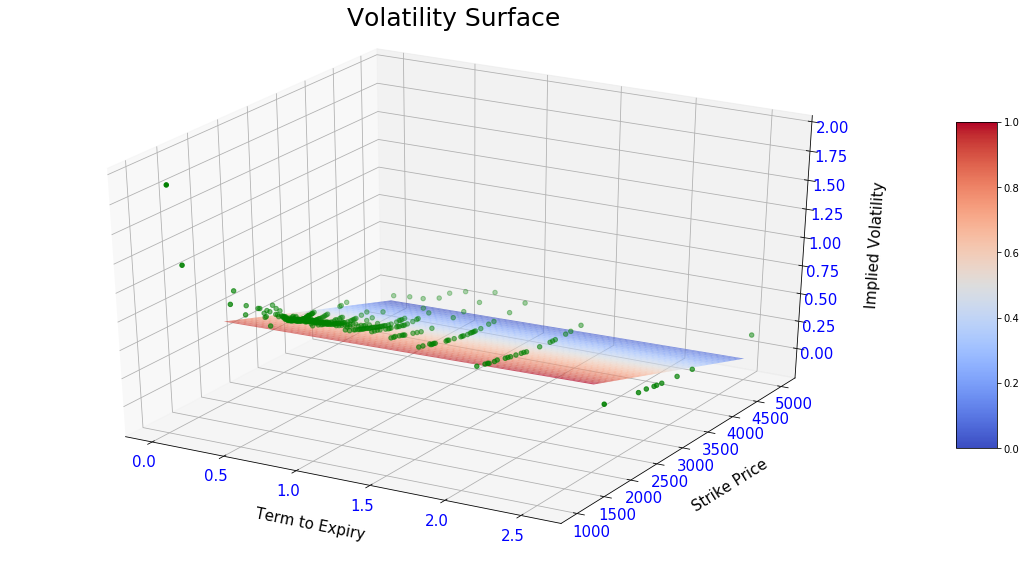

In [34]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
 
# Creamos una malla, sobre la cual graficaremos el plano
xx, yy = np.meshgrid(np.linspace(0, 2.5, num=1000), np.linspace(2000, 5000, num=1000))
 
# calculamos los valores del plano para los puntos x e y
nuevoX = (modelo.coef_[0][0] * xx)
nuevoY = (modelo.coef_[0][1] * yy) 
 
# calculamos los correspondientes valores para z. Debemos sumar el punto de intercepción
z = (nuevoX + nuevoY + modelo.intercept_)
 
# Graficamos el plano
ax.plot_surface(xx, yy, z, alpha = 0.7, cmap=cm.coolwarm)
ax.scatter(xy_m[:, 0], xy_m[:, 1], z_m,  c='g', marker='o')

fig.colorbar(cm.ScalarMappable(cmap=cm.coolwarm), shrink=0.6, aspect=8)

ax.set_xlabel('Term to Expiry', fontsize=15, labelpad=20)
ax.set_ylabel('Strike Price', fontsize=15, labelpad=20)
ax.set_zlabel('Implied Volatility', fontsize=15, labelpad=20)
ax.set_title('Volatility Surface', fontsize=25, y=1.05)

plt.tick_params(axis='both', colors='b', labelsize=15)

2 Condiciones que se deben cumplir en nuestro modelo:

PRIMERO, a mayor es el strike de  una opción call menor será su precio.

SEGUNDO. Un spread de una estrategia butterfly tiene que tener un valor positivo.


(Modelo SABR "stochastic alpha, beta, rho")

-----------------------------------

Ejemplo 1: Cliente quiere cotizar un call a 50 días con Strike 2700. 

In [35]:
t = 50/365
k = 2700

print(t)
print(k)

0.136986301369863
2700


In [36]:
prediccion = modelo.predict([[t, k]])
sigma = prediccion[0][0]
print(sigma)

0.32726751628191464


In [37]:
c = bs_price(cp_flag='c',S = s ,K=k,T=t,r=r,v=sigma,q=q)
print('El precio del call es: ' + str(c))

El precio del call es: 289.1269413769144


In [38]:
df1[105:115]

,Instrument,PUTCALLIND,EXPIR_DATE,STRIKE_PRC,TRDPRC_1,TODAY,EXPIR,IV
653,SPXf192033500.U,CALL,2020-06-19,3350.0,0.90,2020-05-21,0.079452,0.201420
663,SPXf192033750.U,CALL,2020-06-19,3375.0,0.75,2020-05-21,0.079452,0.205021
813,SPXg172010000.U,CALL,2020-07-17,1000.0,1942.52,2020-05-21,0.156164,1.246125
933,SPXg172020000.U,CALL,2020-07-17,2000.0,948.03,2020-05-21,0.156164,0.557456
1157,SPXg172026750.U,CALL,2020-07-17,2675.0,319.00,2020-05-21,0.156164,0.341634
1177,SPXg172027250.U,CALL,2020-07-17,2725.0,274.00,2020-05-21,0.156164,0.316632
1187,SPXg172027500.U,CALL,2020-07-17,2750.0,258.84,2020-05-21,0.156164,0.322232
1207,SPXg172028000.U,CALL,2020-07-17,2800.0,229.20,2020-05-21,0.156164,0.329233
1211,SPXg172028100.U,CALL,2020-07-17,2810.0,211.70,2020-05-21,0.156164,0.302430
1213,SPXg172028150.U,CALL,2020-07-17,2815.0,221.10,2020-05-21,0.156164,0.331833


Ejemplo 2: Cliente quiere cotizar un call a 280 días con Strike 2900. 

In [39]:
t = 280/365
k = 2900

print(t)
print(k)

0.7671232876712328
2900


In [40]:
prediccion = modelo.predict([[t, k]])
sigma = prediccion[0][0]
print(sigma)

0.3001807919089503


In [41]:
c = bs_price(cp_flag='c',S = s ,K=k,T=t,r=r,v=sigma,q=q)
print('El precio del call es: ' + str(c))

El precio del call es: 305.4206818238388


In [42]:
df1[315:330]

,Instrument,PUTCALLIND,EXPIR_DATE,STRIKE_PRC,TRDPRC_1,TODAY,EXPIR,IV
3255,SPXa152134500.U,CALL,2021-01-15,3450.0,32.31,2020-05-21,0.654795,0.189019
3259,SPXa152135000.U,CALL,2021-01-15,3500.0,25.30,2020-05-21,0.654795,0.185819
3261,SPXa152135250.U,CALL,2021-01-15,3525.0,19.80,2020-05-21,0.654795,0.178618
3263,SPXa152135500.U,CALL,2021-01-15,3550.0,17.20,2020-05-21,0.654795,0.176818
3267,SPXa152136000.U,CALL,2021-01-15,3600.0,12.91,2020-05-21,0.654795,0.173817
3275,SPXa152137000.U,CALL,2021-01-15,3700.0,7.20,2020-05-21,0.654795,0.169217
3281,SPXa152137750.U,CALL,2021-01-15,3775.0,5.00,2020-05-21,0.654795,0.169017
3283,SPXa152138000.U,CALL,2021-01-15,3800.0,4.70,2020-05-21,0.654795,0.170617
3289,SPXa152140000.U,CALL,2021-01-15,4000.0,1.80,2020-05-21,0.654795,0.170217
3303,SPXa152147000.U,CALL,2021-01-15,4700.0,0.30,2020-05-21,0.654795,0.185819
